# Retail Data Wrangling and Analytics

In [2]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpg)

```
#make sure you have both Jupyter and PSQL docker container running
docker ps

#Attach a bridge network to both containers so they can communicate with each other
docker network create jarvis-net
#this command works on running containers
docker network connect jarvis-net jarvis-jupyter
docker network connect jarvis-net jarvis-psql

#verify both containers are attached to the jarvis-net
docker network inspect trading-net

#Note: instead of using `localhost`, you should use container names as hostnames.
```

**Data Preperation**

- Use [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame

![](https://i.imgur.com/AmkAP63.jpg)

- Get familair with the transaction date with `df.head()`, `df.sample(10)`, `df.info()`, `df.describe()`, etc..



In [3]:
#install psql "driver"
!pip3 install -q psycopg2-binary sqlalchemy

In [4]:
from sqlalchemy import create_engine

PG_HOST = "jrvs-psql"       
PG_PORT = 5432               
PG_DB   = "postgres"
PG_USER = "postgres"
PG_PW   = "password"

engine_string = f"postgresql+psycopg2://{PG_USER}:{PG_PW}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(engine_string)

# Load table (schema-qualified)
retail_df = pd.read_sql_query("SELECT * FROM public.retail;", engine)

retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
retail_df.info()
retail_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_no    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoice_date  1067371 non-null  datetime64[ns]
 5   unit_price    1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,quantity,unit_price,customer_id
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [13]:
retail_df = pd.read_csv("online_retail_II.csv")


retail_df = retail_df.rename(columns={
    "Invoice": "invoice_no",
    "StockCode": "stock_code",
    "Description": "description",
    "Quantity": "quantity",
    "InvoiceDate": "invoice_date",
    "Price": "unit_price",
    "Customer ID": "customer_id",
    "Country": "country"
})

retail_df["invoice_date"] = pd.to_datetime(
    retail_df["invoice_date"],
    errors="coerce"
)
retail_df["quantity"] = pd.to_numeric(retail_df["quantity"], errors="coerce")
retail_df["unit_price"] = pd.to_numeric(retail_df["unit_price"], errors="coerce")
retail_df["customer_id"] = pd.to_numeric(retail_df["customer_id"], errors="coerce")


retail_df.info()

retail_df.head()
retail_df.describe()

#create and clean copy for analysis
df = retail_df.copy()

df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
df["customer_id"] = pd.to_numeric(df["customer_id"], errors="coerce")


df["line_amount"] = df["quantity"] * df["unit_price"]
df["yyyymm"] = df["invoice_date"].dt.year * 100 + df["invoice_date"].dt.month
df["is_canceled"] = df["invoice_no"].astype(str).str.startswith("C")

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_no    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoice_date  1067371 non-null  datetime64[ns]
 5   unit_price    1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,line_amount,yyyymm,is_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,200912,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,200912,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,200912,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,200912,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,200912,False


# Total Invoice Amount Distribution

---
**Please remove this insturction cell after you are done with coding**

1. Calculate the invoice amount. Note: an invoice consists of one or more items where each item is a row in the df. (hint: you need to `GROUP BY invoice`)
2. Draw the distribution of invoice amount with min, max, median, mod, and mean. However, you will notice many outlier data (e.g. invoices with large amounts). Sample hist and box charts:

![](https://i.imgur.com/N8hsbDa.jpg)

3. Draw the distribution for the first 85 quantiles of the invoice amount data with min, max, median, mod, and mean.


![](https://i.imgur.com/tJrH1qj.jpg)


---

min: -168469.6
max: 168469.6
median: 196.34499999999997
mean: 359.6488880435809
mode: 0.0


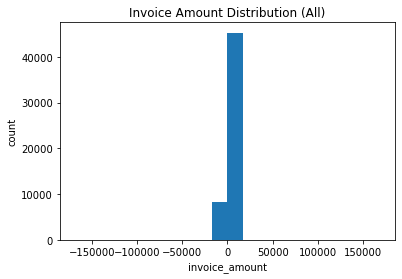

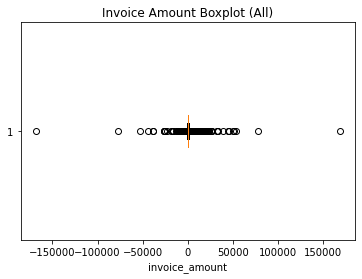

85% cap: 594.0095000000002
min: -168469.6
max: 594.0
median: 141.9
mean: 136.97756815040273
mode: 0.0


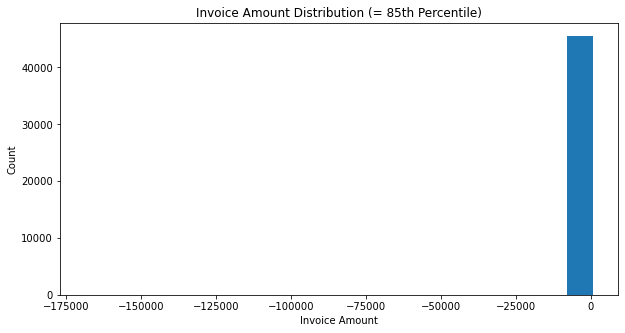

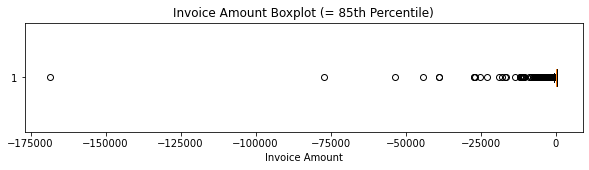

In [9]:

invoice_totals = (
    df.groupby("invoice_no", as_index=False)
      .agg(invoice_amount=("line_amount", "sum"))
)

invoice_totals.describe()


vals = invoice_totals["invoice_amount"].dropna()

print("min:", vals.min())
print("max:", vals.max())
print("median:", vals.median())
print("mean:", vals.mean())
print("mode:", vals.mode().iloc[0] if not vals.mode().empty else np.nan)

plt.figure()
plt.hist(vals, bins=20)
plt.title("Invoice Amount Distribution (All)")
plt.xlabel("invoice_amount")
plt.ylabel("count")
plt.show()

plt.figure()
plt.boxplot(vals, vert=False)
plt.title("Invoice Amount Boxplot (All)")
plt.xlabel("invoice_amount")
plt.show()


q85 = vals.quantile(0.85)
vals_85 = vals[vals <= q85]

print("85% cap:", q85)
print("min:", vals_85.min())
print("max:", vals_85.max())
print("median:", vals_85.median())
print("mean:", vals_85.mean())
print("mode:", vals_85.mode().iloc[0] if not vals_85.mode().empty else np.nan)

plt.figure(figsize=(10, 5))
plt.hist(vals_85, bins=20)
plt.title("Invoice Amount Distribution (= 85th Percentile)")
plt.xlabel("Invoice Amount")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 2))
plt.boxplot(vals_85, vert=False)
plt.title("Invoice Amount Boxplot (= 85th Percentile)")
plt.xlabel("Invoice Amount")
plt.show()




# Monthly Placed and Canceled Orders

---
**Please remove this insturction cell after you are done with coding**

- The attribute information (see the `project kick-off` section) contains useful information that helps you to identify canceled orders
- To simplify the problem, you can assume that there are two invoice numbers for each canceled order (one for the original invoice and one for the canceled invoice). Therefore, `# of placed orders = total # of orders - 2 * canceled order`. Furthermore, you can also assume the original invoice and canceled invoice are on always on the same day (this eliminate the case where the original invoice and canceled invoices are on different months)
- hints: you might want to create a new integer column with YYYYMM format. e.g. `2009-12-01 07:45:00 -> 200912` which allows easy GROUP BY.

**Sample Plot:**

![](https://i.imgur.com/tmLsPDf.jpg)

---

In [15]:
invoice_level = (
    df.groupby(["yyyymm", "invoice_no"], as_index=False)
      .agg(is_canceled=("is_canceled", "max"))
)

monthly = (
    invoice_level.groupby("yyyymm", as_index=False)
    .agg(
        total_invoices=("invoice_no", "nunique"),
        canceled_invoices=("is_canceled", "sum")
    )
    .sort_values("yyyymm")
)

# Ticket assumption: 2 invoice numbers per canceled order
monthly["canceled_orders"] = monthly["canceled_invoices"]

# Ticket formula: placed = total - 2 * canceled_orders
monthly["placed_orders"] = monthly["total_invoices"] - (2*monthly["canceled_orders"])

monthly.head()

,yyyymm,total_invoices,canceled_invoices,canceled_orders,placed_orders
0,200912,2330,401,401,1528
1,201001,1633,300,300,1033
2,201002,1969,240,240,1489
3,201003,2367,407,407,1553
4,201004,1892,304,304,1284


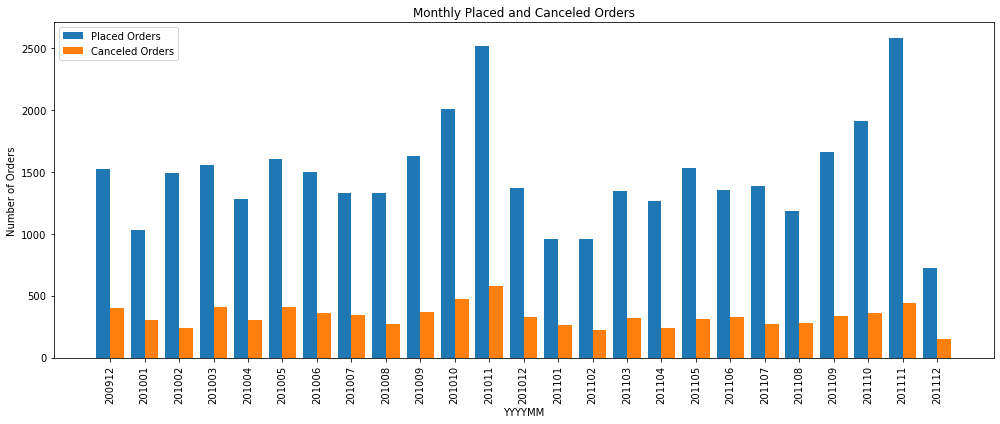

In [16]:
# X positions
x = np.arange(len(monthly["yyyymm"]))
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Bars
plt.bar(
    x - bar_width / 2,
    monthly["placed_orders"],
    width=bar_width,
    label="Placed Orders"
)

plt.bar(
    x + bar_width / 2,
    monthly["canceled_orders"],
    width=bar_width,
    label="Canceled Orders"
)

# Labels & formatting
plt.xticks(x, monthly["yyyymm"].astype(str), rotation=90)
plt.xlabel("YYYYMM")
plt.ylabel("Number of Orders")
plt.title("Monthly Placed and Canceled Orders")
plt.legend()
plt.tight_layout()
plt.show()



# Monthly Sales

---
**Please remove this insturction cell after you are done with coding**


- Calculate the monthly sales data
- Plot a chart to show monthly sales (e.g. x-asix=year_month, y-axis=sales_amount)

![](https://i.imgur.com/k1KOqKO.jpg)

---

# Monthly Sales Growth


---
**Please remove this insturction cell after you are done with coding**

- Calculate monthly sales percentage growth data
- Plot a chart to show the growth percentage

![](https://i.imgur.com/J3btp8j.jpg)

---

# Monthly Active Users

---
**Please remove this insturction cell after you are done with coding**

- Compute # of active users (e.g. unique `CusotomerID`) for each month
- Plot a bar chart

![](https://i.imgur.com/eFYp8VF.jpg)

---

# New and Existing Users



---
**Please remove this insturction cell after you are done with coding**

- Plot a diagram to show new and exiting user for each month.
- A user is identified as a new user when he/she makes the first purchase
- A user is identified as an existing user when he/she made purchases in the past
- hints:
  - find out the first purchase year-month for each user and then join this data with the transactional data to help you identified new/exiting users

![](https://i.imgur.com/nWjnrpr.jpg)

---

## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

# RFM Segmentation

---
**Please remove this insturction cell after you are done with coding**
RFM segmentation categorizes your customers into different segments, according to their interactions with your website, which will allow you to subsequently approach these groups in the most effective way. In this article, we will show you how to make an RFM segmentation based on an RFM score combining all three RFM parameters together and allowing you to divide your customers into 11 different segments. 

- [RFM Segmentation business cases](https://docs.exponea.com/docs/rfm-segmentation-business-use)

- [RFM Segmentation Guide](https://docs.exponea.com/docs/rfm-segmentation-business-use)

As you can see, computing RFM segmentation requires extensive domain knowledge in marketing which is out of the scope in this project. In practice, you will work with BA/DA to figure out how to compute RFM segments. To simplify this project, a [sample RFM segmentation Notebook](https://github.com/jarviscanada/jarvis_data_eng_demo/blob/feature/data/python_data_wrangling/ipynb/customer-segmentation-with-rfm-score.ipynb) is provided. You are responsible to understand everything from that Notebook and then integrate it into yours. 

- Download the [sample notebook](https://github.com/jarviscanada/jarvis_data_eng_demo/blob/feature/data/python_data_wrangling/ipynb/customer-segmentation-with-rfm-score.ipynb) and import to your Jupyter Notebook or VSCode
- Run the notebook and understand all cells
- Read the remark section at the end of the notebook. You will need this information when writing the README file
- Integrate the RFM segmentation calculation into your notebook

---